The purpose of this notebook is to provide a USA level analysis while portraying some of the analysis methods we can 
partake in. 

In [2]:
# loading packages we will use into our notebook environment
import pandas as pd
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# setting up some general plot params
# figures dots per inch
plt.rcParams['figure.dpi'] = 100

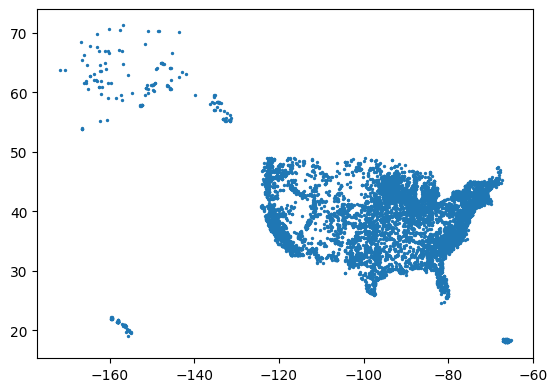

In [3]:
# loading our data into the env now
plants = gpd.read_file('input_data/Power_Plants.geojson')
plants.plot(markersize=2)
plt.show()

In [4]:
# showing some info on the power plants
plants.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12008 entries, 0 to 12007
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   OBJECTID        12008 non-null  int64   
 1   Plant_Code      12008 non-null  int64   
 2   Plant_Name      12008 non-null  object  
 3   Utility_ID      12008 non-null  int64   
 4   Utility_Name    12004 non-null  object  
 5   sector_name     12008 non-null  object  
 6   Street_Address  11984 non-null  object  
 7   City            11991 non-null  object  
 8   County          11965 non-null  object  
 9   State           12008 non-null  object  
 10  Zip             11990 non-null  float64 
 11  PrimSource      12008 non-null  object  
 12  source_desc     12008 non-null  object  
 13  tech_desc       12008 non-null  object  
 14  Install_MW      12008 non-null  float64 
 15  Total_MW        12008 non-null  float64 
 16  Bat_MW          461 non-null    float64 
 17  Bio_

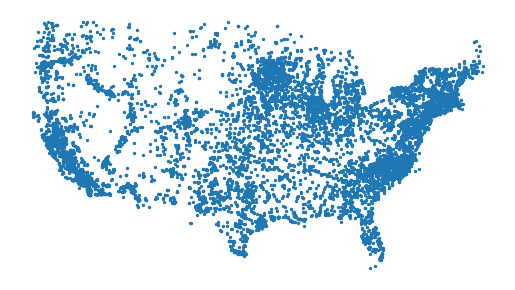

In [5]:
# removing any non mainland power plants
mainland_plants = plants[~plants['State'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# applying CRS 3857 aka mercator projection
mainland_plants = mainland_plants.to_crs('EPSG:3857')

axis = mainland_plants.plot(markersize=2)

# turning off map frame and axis labels
axis.set_axis_off()

plt.show()

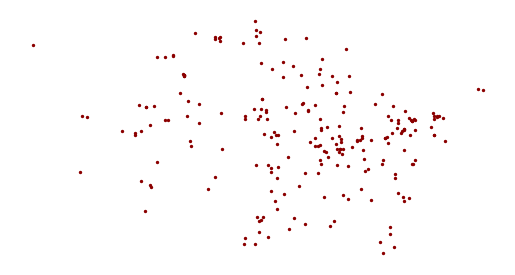

In [6]:
# let's create some power plant type dataframes
coal_plants = mainland_plants[mainland_plants['Coal_MW'] > 0]
solar_plants = mainland_plants[mainland_plants['Solar_MW'] > 0]
wind_plants = mainland_plants[mainland_plants['Wind_MW'] > 0]
nuclear_plants = mainland_plants[mainland_plants['Nuclear_MW'] > 0]
oil_plants = mainland_plants[mainland_plants['Crude_MW'] > 0]
gas_plants = mainland_plants[mainland_plants['NG_MW'] > 0]
battery_plants = mainland_plants[mainland_plants['Bat_MW'] > 0]

axis = coal_plants.plot(markersize=2, color='darkred')

axis.set_axis_off()

plt.show()

In [7]:
# loading in our basemap
states = gpd.read_file('input_data/2015-2019-acs-states.geojson')

# taking out non mainland states
states = states[~states['ST'].isin(['AK', 'HI', 'PR'])]

states = states.to_crs(mainland_plants.crs)

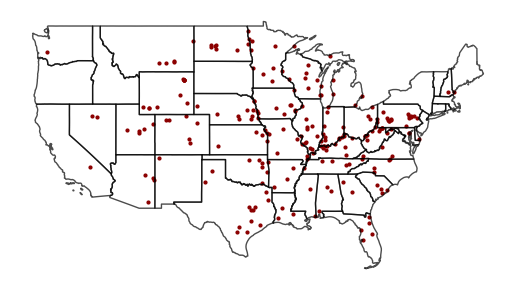

In [8]:
# now lets plot our coal plants and the base map together
axis = coal_plants.plot(markersize=4, color='darkred')
states.plot(facecolor='none', edgecolor='black', ax=axis, alpha=0.7)

axis.set_axis_off()

plt.show()

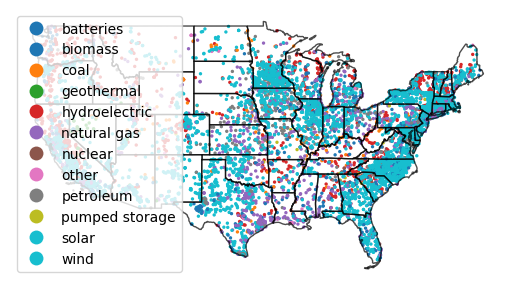

In [9]:
# mapping dots by primary source of energy
axis = mainland_plants.plot('PrimSource', legend=True, markersize=2)

states.plot(facecolor='none', edgecolor='black', alpha=0.7, ax=axis)

axis.set_axis_off()

plt.show()

In [10]:
def create_facet(data, col_val, facet_by, bin_num=10, colwrap=3, set_title='Please Insert Title'):

    # here we will be sorting by aggregate MW depending on the source type
    #data = data[data[col_val] > 0]

    # calculating aggregate values
    aggregated_data = data.groupby(facet_by)[col_val].sum()

    # sorting the facets cols based on aggregate values
    sorting_map = aggregated_data.sort_values(ascending=False).index.to_list()

    # ONLY TAKING THE TOP N STATES
    sorting_map = sorting_map[:6]

    data_sorted = data.loc[data[facet_by].isin(sorting_map)]

    graph = sns.FacetGrid(data_sorted, col=facet_by, col_wrap=colwrap, aspect=1.6)
    graph.map(sns.histplot, col_val, kde=True, bins=bin_num)

    graph.fig.suptitle(set_title, y=1.05, fontsize=12)

    plt.show()


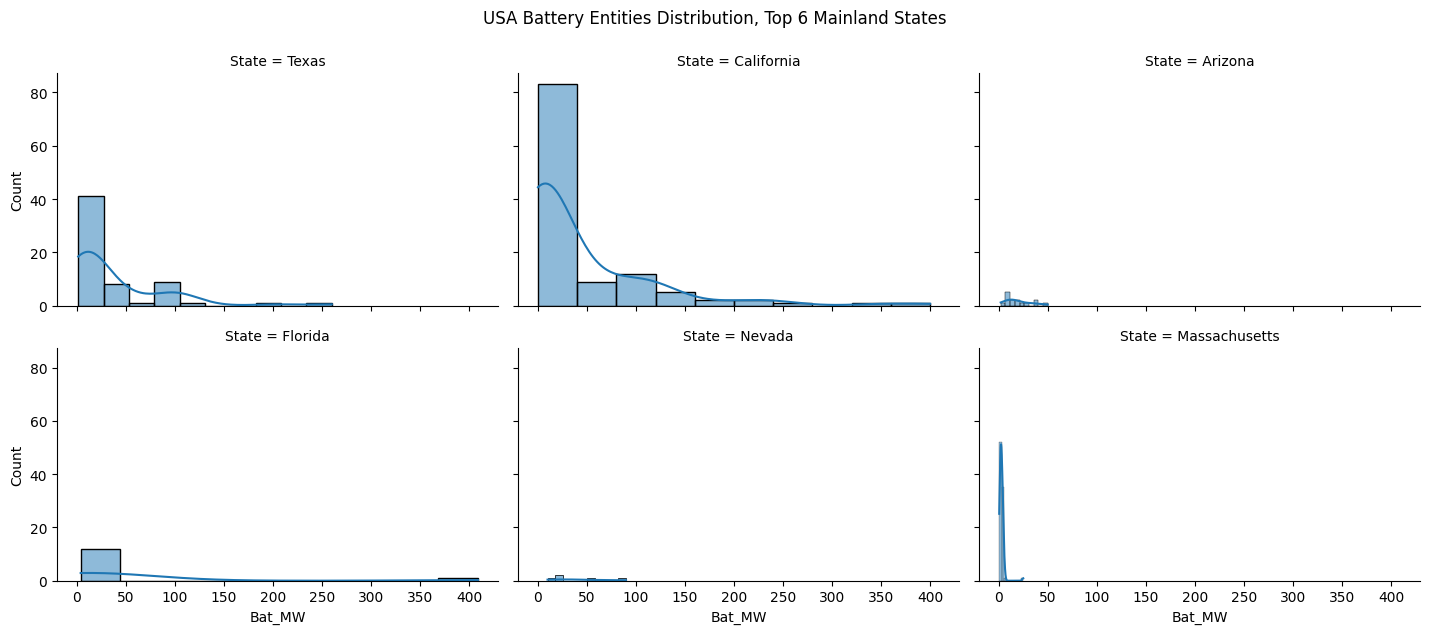

In [11]:
create_facet(data=mainland_plants, facet_by='State', col_val='Bat_MW', set_title='USA Battery Entities Distribution, Top 6 Mainland States')


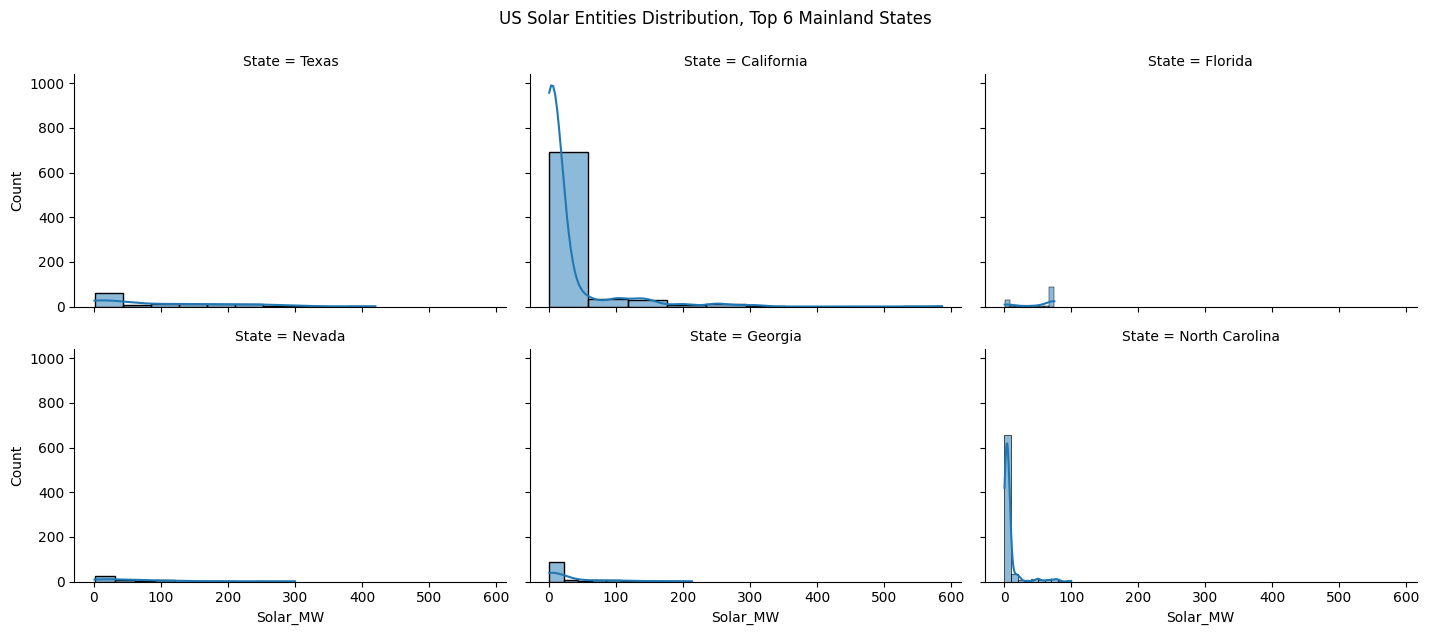

In [12]:
create_facet(data=mainland_plants, facet_by='State', col_val='Solar_MW', set_title='US Solar Entities Distribution, Top 6 Mainland States')


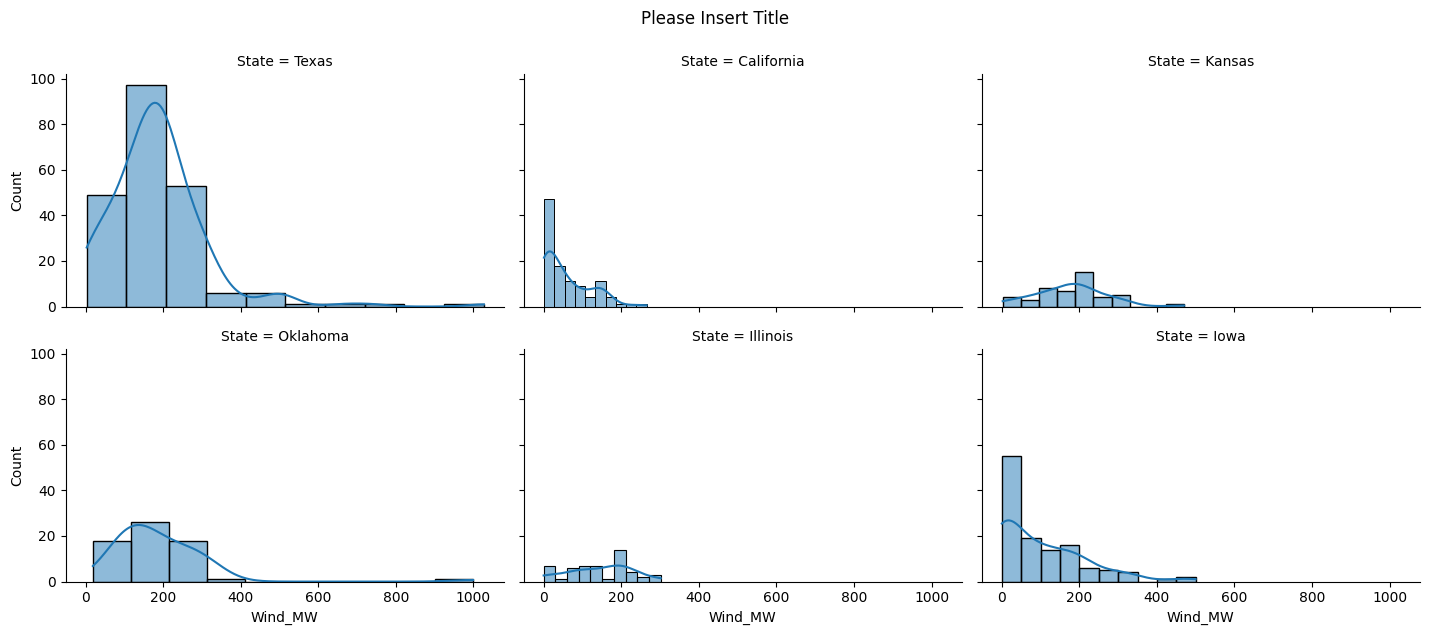

In [13]:
create_facet(data=mainland_plants, facet_by='State', col_val='Wind_MW')


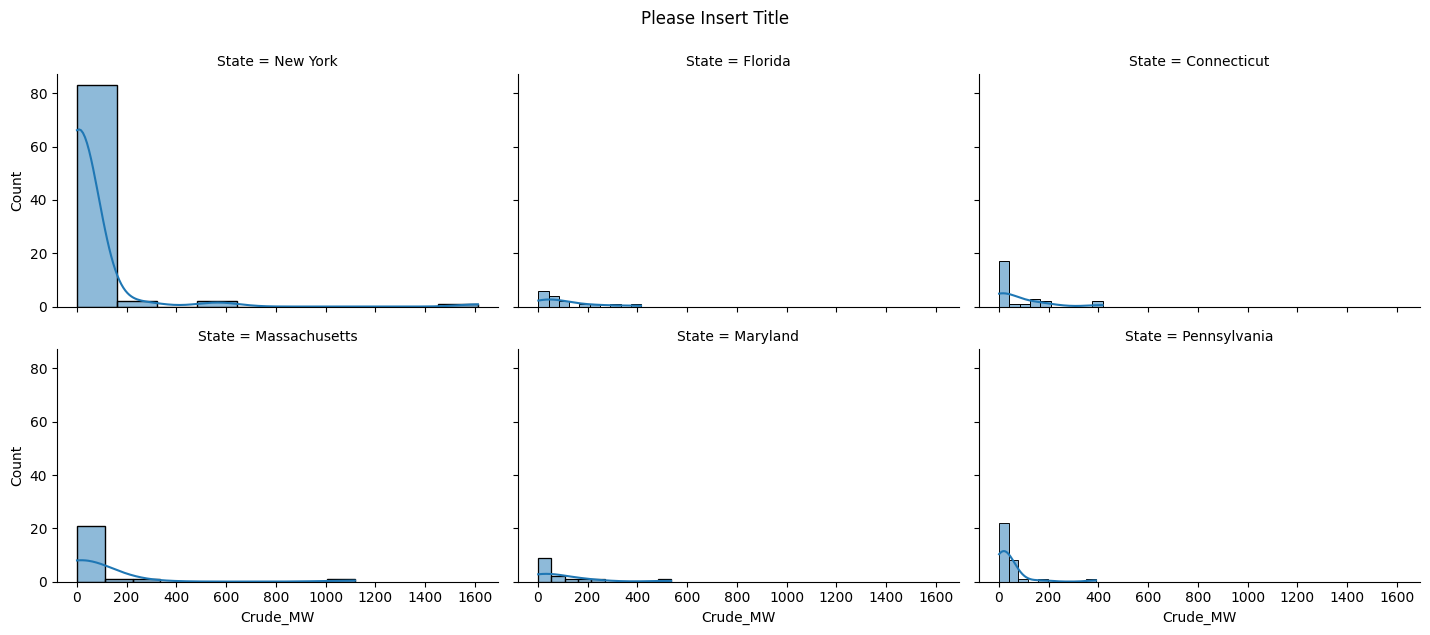

In [14]:
create_facet(data=mainland_plants, facet_by='State', col_val='Crude_MW')


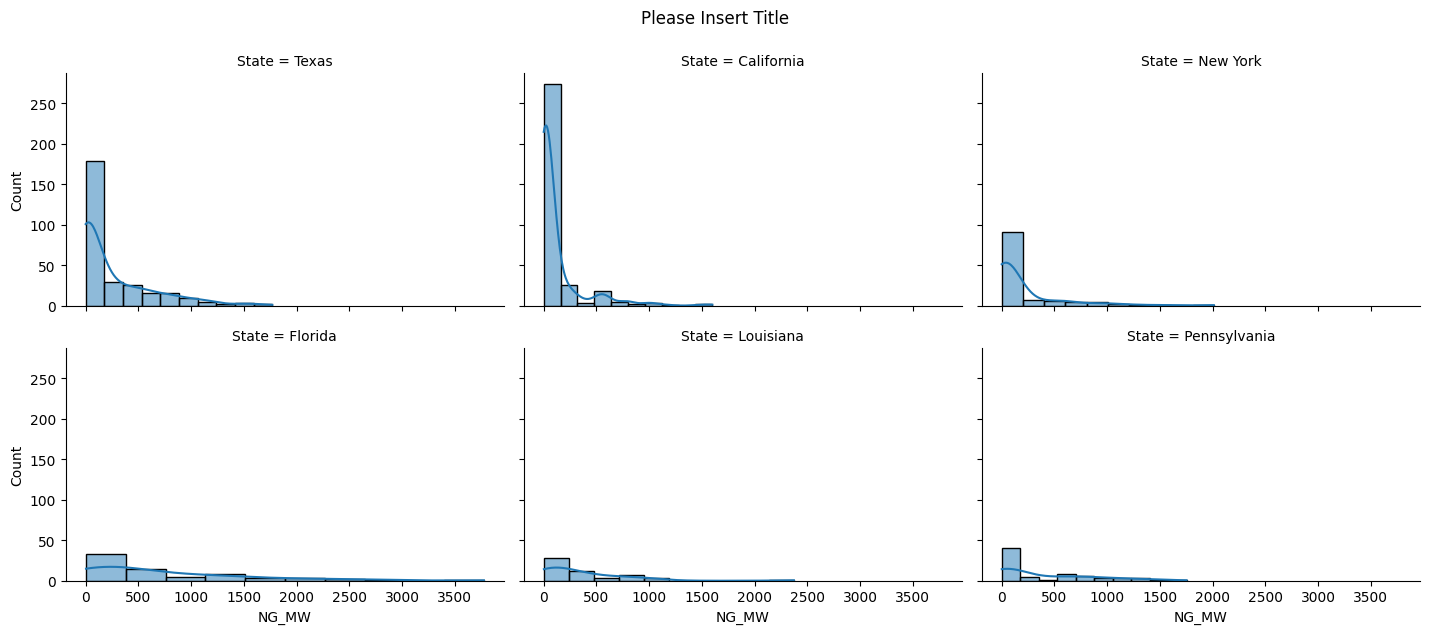

In [15]:
create_facet(data=mainland_plants, facet_by='State', col_val='NG_MW')


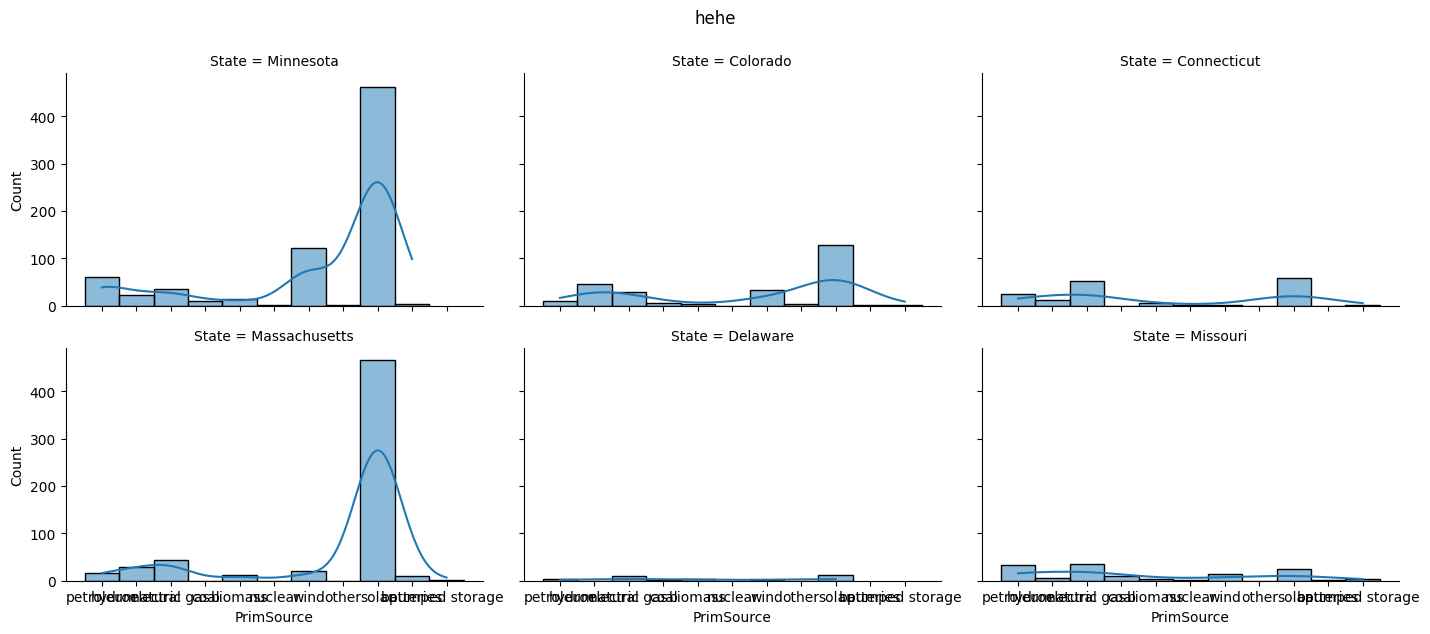

In [16]:
create_facet(data=mainland_plants, facet_by='State', col_val='PrimSource', set_title='hehe')


In [17]:
# printing out the frequency of values in the PrimSource columns
print(mainland_plants['PrimSource'].value_counts())

PrimSource
solar             5070
natural gas       1953
hydroelectric     1367
wind              1293
petroleum          762
biomass            627
batteries          215
coal               211
other               74
geothermal          66
nuclear             54
pumped storage      35
Name: count, dtype: int64


In [18]:
# converting the frequency of values into a percentage of total primary sources of energy 
print(mainland_plants['PrimSource'].value_counts() / mainland_plants['PrimSource'].count() * 100)

PrimSource
solar             43.233564
natural gas       16.653876
hydroelectric     11.656860
wind              11.025838
petroleum          6.497826
biomass            5.346636
batteries          1.833376
coal               1.799267
other              0.631022
geothermal         0.562804
nuclear            0.460476
pumped storage     0.298457
Name: count, dtype: float64


In [19]:
# row aggregation 
# listing the total sum of aggregate nameplate capacity in MW from different type of primary sources of energy
print(mainland_plants.groupby('PrimSource')['Install_MW'].sum())


PrimSource
batteries           5919.1
biomass            13732.4
coal              201408.5
geothermal          3996.1
hydroelectric      79351.3
natural gas       572387.8
nuclear           100790.8
other               2743.7
petroleum          27867.5
pumped storage     22124.8
solar              79396.0
wind              145057.2
Name: Install_MW, dtype: float64


In [20]:
# listing median plant size by primary fuel source
print(mainland_plants.groupby('PrimSource')['Install_MW'].median())

PrimSource
batteries            9.90
biomass              6.60
coal               734.00
geothermal          32.50
hydroelectric        7.50
natural gas         73.80
nuclear           1875.75
other               20.65
petroleum            7.20
pumped storage     424.00
solar                3.00
wind                97.50
Name: Install_MW, dtype: float64


In [21]:
# working on sorted tables now
primary_sources = mainland_plants.groupby('PrimSource')['Install_MW'].median()

# sorting values in descending order
primary_sources = primary_sources.sort_values(ascending=False)

# resetting index in order to prind out a dataframe
primary_sources = primary_sources.reset_index()

print(primary_sources)

        PrimSource  Install_MW
0          nuclear     1875.75
1             coal      734.00
2   pumped storage      424.00
3             wind       97.50
4      natural gas       73.80
5       geothermal       32.50
6            other       20.65
7        batteries        9.90
8    hydroelectric        7.50
9        petroleum        7.20
10         biomass        6.60
11           solar        3.00


In [22]:
print(coal_plants['PrimSource'])

2       natural gas
17      natural gas
28             coal
29             coal
55             coal
           ...     
5330           coal
5331           coal
5335           coal
5342           coal
9030           coal
Name: PrimSource, Length: 230, dtype: object


In [23]:
# getting a better grasp of distribution statistics
def distribution_stats(data):

    '''
     Takes a dataframe as an argument and returns disribution stats from the provided data.
    '''
    print('Median Plant Size: ' + str(data['Install_MW'].median().astype(float).round(1)) + ' MW.')
    print('Mean Plant Size: ' + str(data['Install_MW'].mean().astype(float).round(1)) + ' MW.')
    print('Plant Size Standard Deviation: ' + str(data['Install_MW'].std().astype(float).round(1)) + ' MW')
    print('\n')


distribution_stats(data=coal_plants)
distribution_stats(data=solar_plants)
distribution_stats(data=wind_plants)
distribution_stats(data=battery_plants)
distribution_stats(data=nuclear_plants)


Median Plant Size: 786.2 MW.
Mean Plant Size: 986.3 MW.
Plant Size Standard Deviation: 848.3 MW


Median Plant Size: 3.0 MW.
Mean Plant Size: 17.7 MW.
Plant Size Standard Deviation: 62.1 MW


Median Plant Size: 94.9 MW.
Mean Plant Size: 111.6 MW.
Plant Size Standard Deviation: 111.9 MW


Median Plant Size: 8.3 MW.
Mean Plant Size: 57.7 MW.
Plant Size Standard Deviation: 165.5 MW


Median Plant Size: 1875.8 MW.
Mean Plant Size: 1866.5 MW.
Plant Size Standard Deviation: 767.1 MW




In [24]:
# working on ranking our data
coal_plants = coal_plants.sort_values('Install_MW', ascending=False)

# coal_plants = coal_plants.reset_index()

coal_plants[['Plant_Name', 'State', 'Install_MW']].head()



,Plant_Name,State,Install_MW
1409,W A Parish,Texas,4008.4
394,Bowen,Georgia,3498.6
367,Crystal River,Florida,3449.0
1720,Gibson,Indiana,3339.5
768,Monroe (MI),Michigan,3293.1


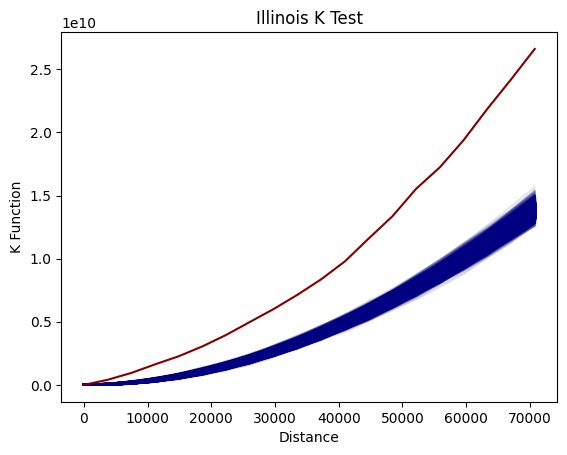

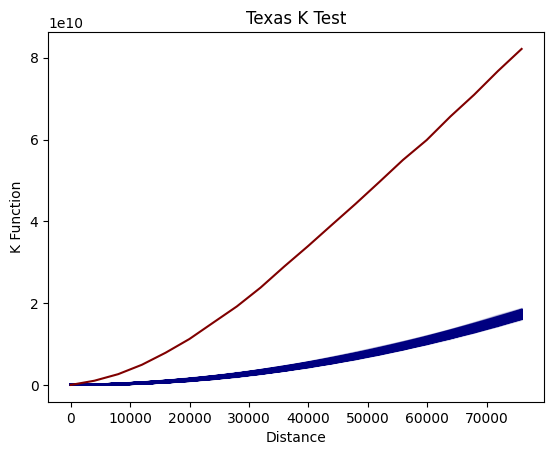

In [26]:
# point autocorrelation analysis
import numpy as np
import pointpats

def state_ripley_k_test(data, choose_state):
    '''
    Purpose is to perform K test.
    Blue line represents simulated point tests. 
    Red line represents observed values from data. 
    Red > Blue indicates clustering at given distance
    Red < Blue indicated dispersion at given distance
    '''

    state_plants = data[data['State'] == choose_state]
    state_points = np.column_stack((state_plants.centroid.x, state_plants.centroid.y))

    # now we are performing ripley's k test
    state_k_test = pointpats.k_test(state_points, keep_simulations=True)

    # plotting the randomized simulations
    plt.plot(state_k_test.support, state_k_test.simulations.T, color='navy', alpha=0.1)

    # plotting observed values
    plt.plot(state_k_test.support, state_k_test.statistic, color='maroon')

    # relabeling our x and y axis
    plt.xlabel('Distance')
    plt.ylabel('K Function')

    # creating our label 
    plt.title(f'{choose_state} K Test')

    plt.show()



state_ripley_k_test(data=mainland_plants, choose_state='Illinois')
state_ripley_k_test(data=mainland_plants, choose_state='Texas')

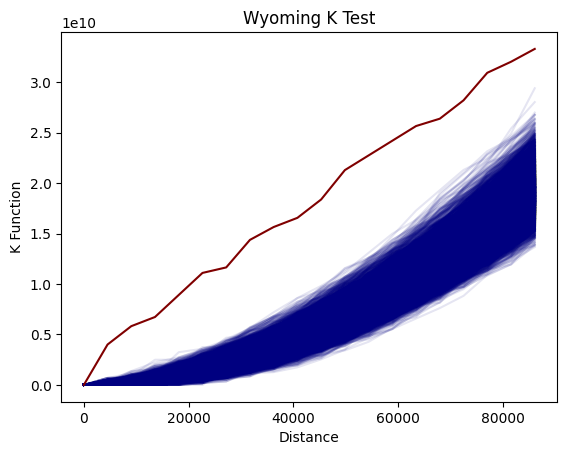

In [27]:
state_ripley_k_test(data=mainland_plants, choose_state='Wyoming')

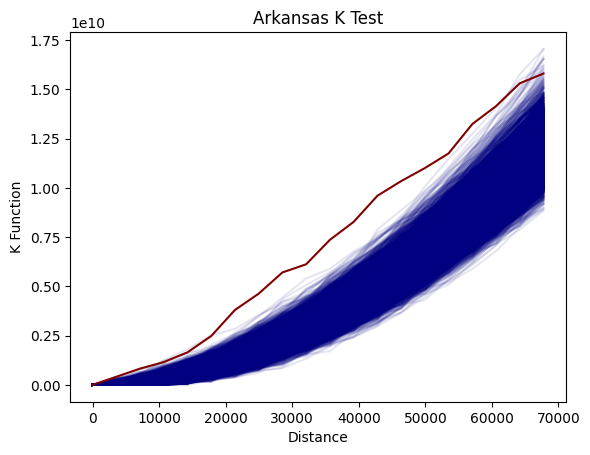

In [28]:
state_ripley_k_test(data=mainland_plants, choose_state='Arkansas')

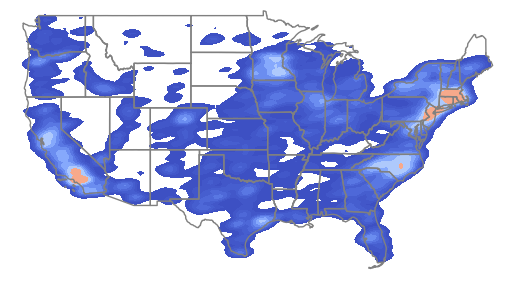

In [29]:
# kernel density plot by count 
axis = sns.kdeplot(x=mainland_plants.centroid.x, y=mainland_plants.centroid.y, 
                   fill=True, gridsize=100, bw_adjust=0.2, cmap='coolwarm')

states.plot(facecolor='none', edgecolor='gray', ax=axis)

axis.set_axis_off()

plt.show()

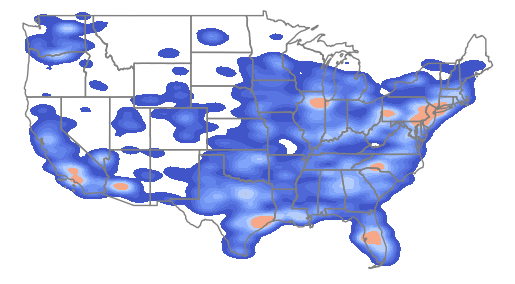

In [30]:
# weighing the graph by the plant installed capacity
axis = sns.kdeplot(x=mainland_plants.centroid.x, y=mainland_plants.centroid.y, 
                   weights=mainland_plants['Install_MW'], 
                   fill=True, gridsize=100, bw_adjust=0.2, cmap='coolwarm')


states.plot(facecolor='none', edgecolor='gray', ax=axis)

axis.set_axis_off()

plt.show()

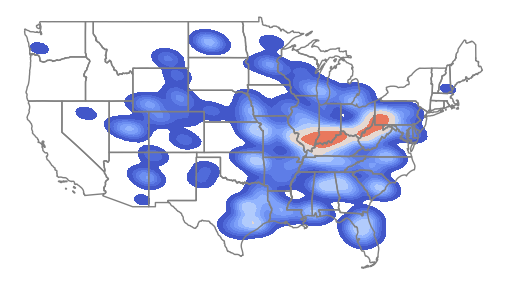

In [31]:
# now let's do the same but only for coal plants
axis = sns.kdeplot(x=coal_plants.centroid.x, y=coal_plants.centroid.y, 
                   weights=mainland_plants['Install_MW'], 
                   fill=True, gridsize=100, bw_adjust=0.3, cmap='coolwarm')

states.plot(facecolor='none', edgecolor='gray', ax=axis)

axis.set_axis_off()

plt.show()

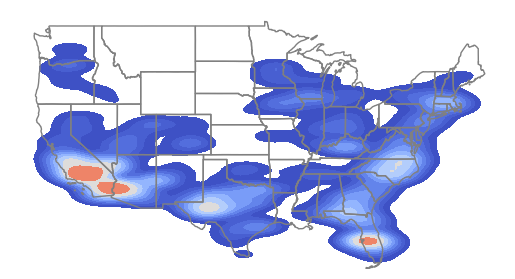

In [32]:
# okay now let's look at solar plants
axis = sns.kdeplot(x=solar_plants.centroid.x, y=solar_plants.centroid.y,
                   weights=mainland_plants['Install_MW'], 
                   fill=True, gridsize=100, bw_adjust=0.3, cmap='coolwarm')

states.plot(facecolor='none', edgecolor='gray', ax=axis)

axis.set_axis_off()

plt.show()

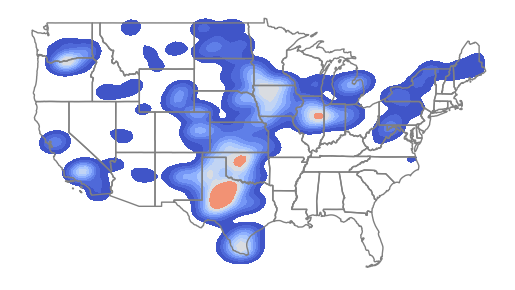

In [33]:
# okay now let's look at solar plants
axis = sns.kdeplot(x=wind_plants.centroid.x, y=wind_plants.centroid.y,
                   weights=mainland_plants['Install_MW'], 
                   fill=True, gridsize=100, bw_adjust=0.3, cmap='coolwarm')

states.plot(facecolor='none', edgecolor='gray', ax=axis)

axis.set_axis_off()

plt.show()

In [34]:
# moving on to attribute aggregation 
# beginning by conducting some attribute join analysis
coal_states = coal_plants.groupby('State')['Install_MW'].sum()

# now we are sorting values in descending order
coal_states = coal_states.sort_values(ascending=False)

# reseting index to return a df
coal_states = coal_states.reset_index()

print(coal_states.head())

           State  Install_MW
0          Texas     18933.1
1        Indiana     15823.3
2       Kentucky     13389.7
3  West Virginia     13090.2
4       Missouri     10847.7


In [35]:
print(coal_states.tail())

            State  Install_MW
34     Washington       729.9
35  New Hampshire       667.6
36       Delaware       464.1
37   South Dakota       451.0
38     California        62.5


AttributeError: Line2D.set() got an unexpected keyword argument 'scheme'

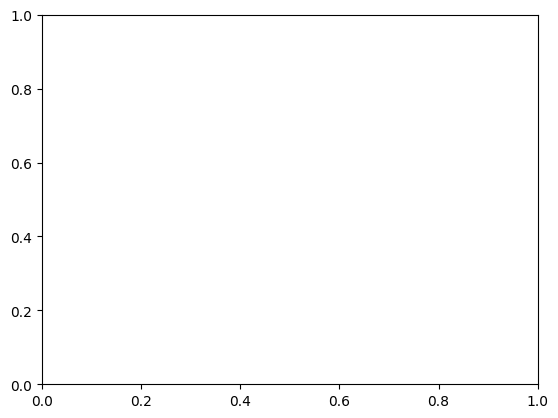

In [37]:
# importing the mapclassify package so that we an use scheme
import mapclassify

# Create a classifier object using mapclassify
classifier = mapclassify.NaturalBreaks(
    coal_states['Install_MW'], k=5  # Adjust k for the desired number of classes
)

# attribute joining to create cholorpleth maps
coal_states = states.merge(coal_states, how='left', left_on='Name', right_on='State')

# filling any empty values with 0
coal_states['Install_MW'] = coal_states['Install_MW'].fillna(0)

# now we are plotting a chloropleth map to show the density of coal plant capacity by state
axis = coal_states.plot('Install_MW', legend=True, 
                        scheme=classifier, cmap='coolwarm', 
                        legend_kwds={'bbox_to_anchor': (0.2, 0.4)})

axis.set_axis_off()

plt.show()